# 03 — Subgroup SHAP Analysis

## 1. Overview

This notebook performs subgroup SHAP analyses both within and across regimes. For each regime, SHAP values are computed separately for each model and each subgroup. These SHAP outputs are then converted into feature‑rank matrices to evaluate how stable feature importance is:

* Within each regime:  
We compare models inside the same regime to assess how consistently they rank features for a given subgroup.

* Across regimes:  
We compare subgroup‑level feature rankings across different regimes to identify shared patterns and regime‑specific differences.

In [6]:
import sys
import os

# Get the project root (one level above the notebook folder)
project_root = os.path.abspath("..")

# Add it to Python path
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)


Project root added: C:\Users\shari\OneDrive\MSc Data Science and Society\Thesis_DSS_2026


## 2. Imports

In [8]:
import numpy as np
import pandas as pd

import pickle
import joblib

import sys
import os

# Now import the functions
from src.shap_subgroup import (
    build_subgroups,   
    attach_all_subgroups,
    subgroup_rank_variance,
    plot_all_subgroup_profiles,
    compute_subgroup_shap_analysis,
    rename_features
)

from src.shap_analysis import (
    compute_shap_xgb_per_regime,
    compute_across_regime_shap_common_features,
    summarize_volatile_stable_features,
    safe_save_plot
)

# ============================================
# Optional: Warnings Control
# ============================================
import warnings
warnings.filterwarnings("ignore")

## 3. Load Datasets

In [10]:
# ---------------------------------------------------------
# Project paths
# ---------------------------------------------------------
project_root = os.path.abspath("..")
sys.path.append(project_root) if project_root not in sys.path else None

data_dir = os.path.join(project_root, "data")
output_dir = "shap_results_saved"

print("Project root:", project_root)
print("Data directory:", data_dir)

# ---------------------------------------------------------
# Load saved SHAP results
# ---------------------------------------------------------
with open(os.path.join(output_dir, "across_regime_results.pkl"), "rb") as f:
    across_regime_results_loaded = pickle.load(f)

with open(os.path.join(output_dir, "within_regime_results.pkl"), "rb") as f:
    shap_results_per_regime = pickle.load(f)

# ---------------------------------------------------------
# Load model evaluation results
# ---------------------------------------------------------
ALL_RESULTS = joblib.load("results/all_results.joblib")

# ---------------------------------------------------------
# Load raw data for regimes
# ---------------------------------------------------------
df_clean = pd.read_parquet(os.path.join(data_dir, "clean", "df_clean.parquet"))

df_regime_a = pd.read_parquet(os.path.join(data_dir, "regimes", "regime_a.parquet"))
df_regime_b = pd.read_parquet(os.path.join(data_dir, "regimes", "regime_b.parquet"))
df_regime_c = pd.read_parquet(os.path.join(data_dir, "regimes", "regime_c.parquet"))


Project root: C:\Users\shari\OneDrive\MSc Data Science and Society\Thesis_DSS_2026
Data directory: C:\Users\shari\OneDrive\MSc Data Science and Society\Thesis_DSS_2026\data


## 4. Subgroup Analysis

Number of common features: 63
Example: ['binary__088', 'binary__095', 'binary__096', 'binary__101', 'binary__102', 'binary__390', 'binary__391', 'binary__392', 'binary__393', 'binary__394']

=== Running subgroup SHAP analysis for Regime A ===


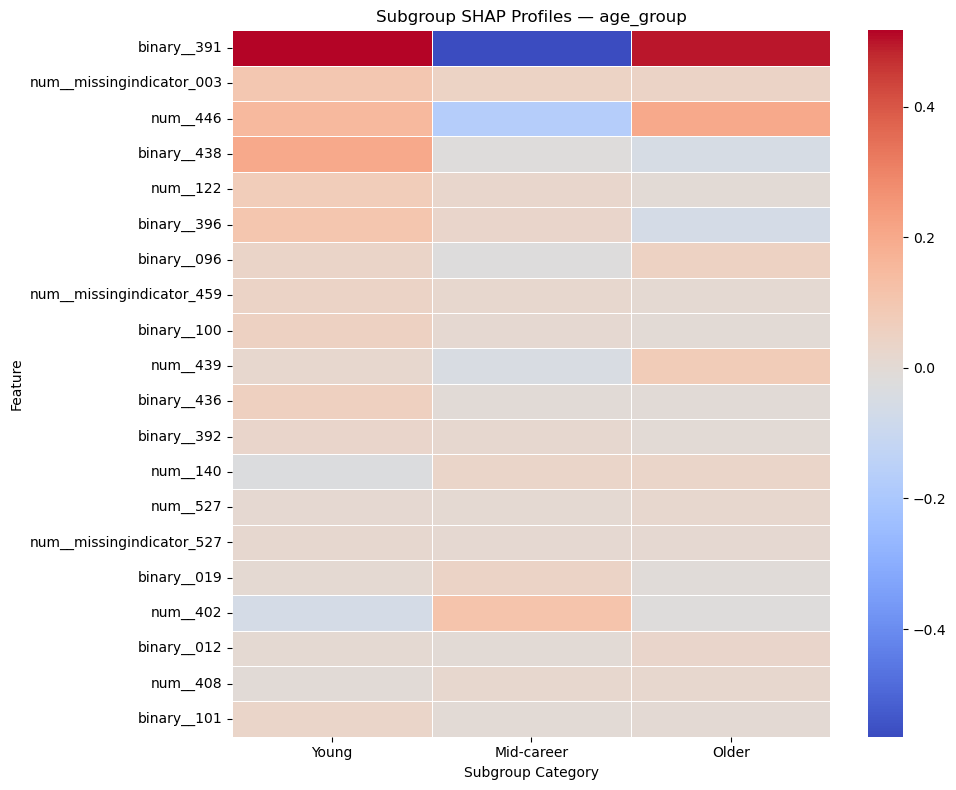

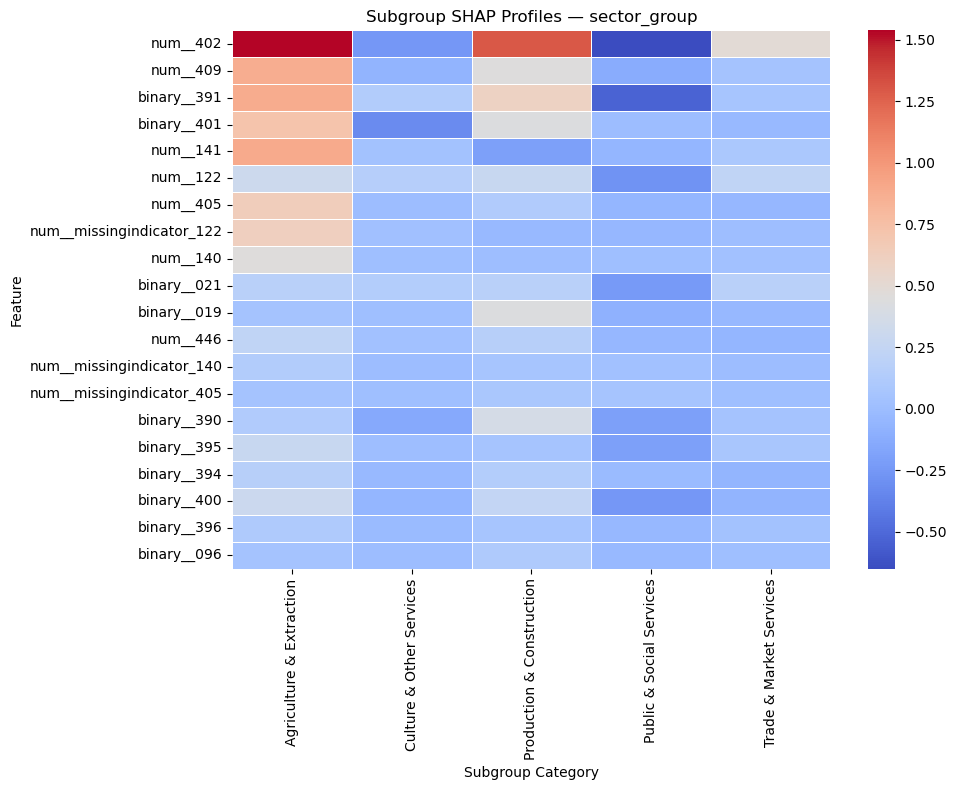

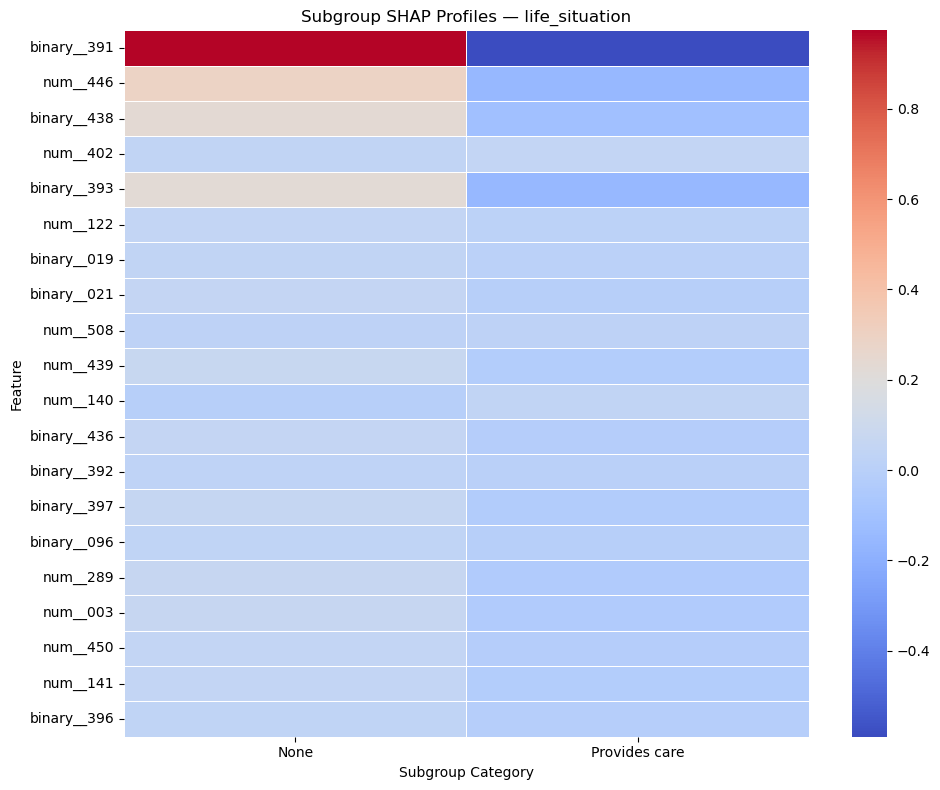

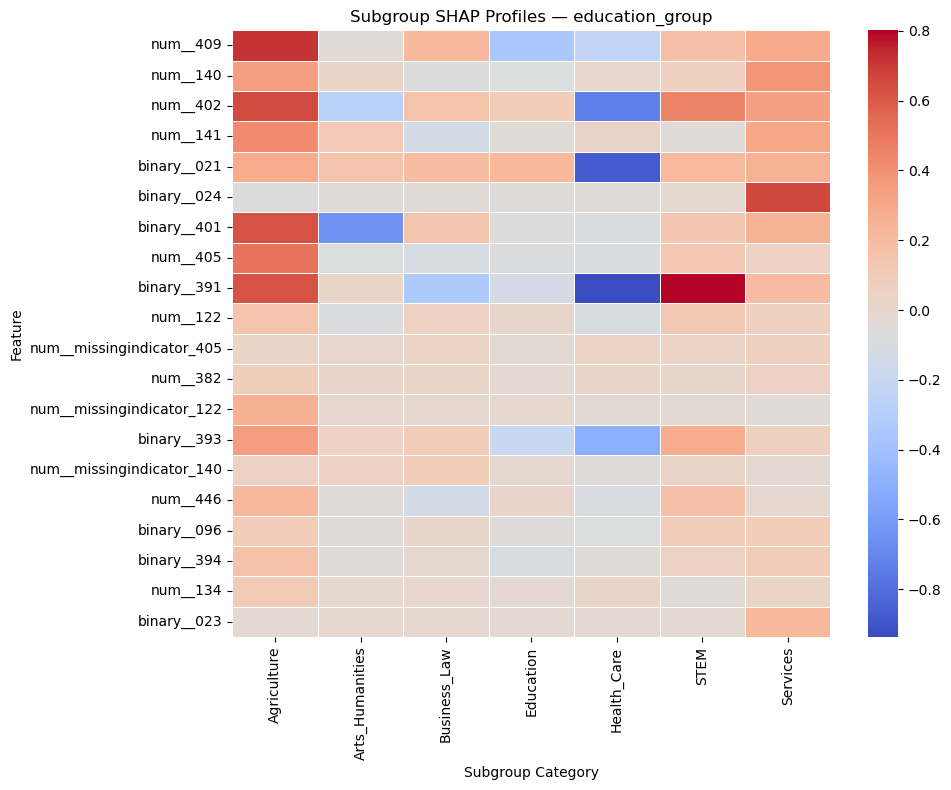


=== Running subgroup SHAP analysis for Regime B ===


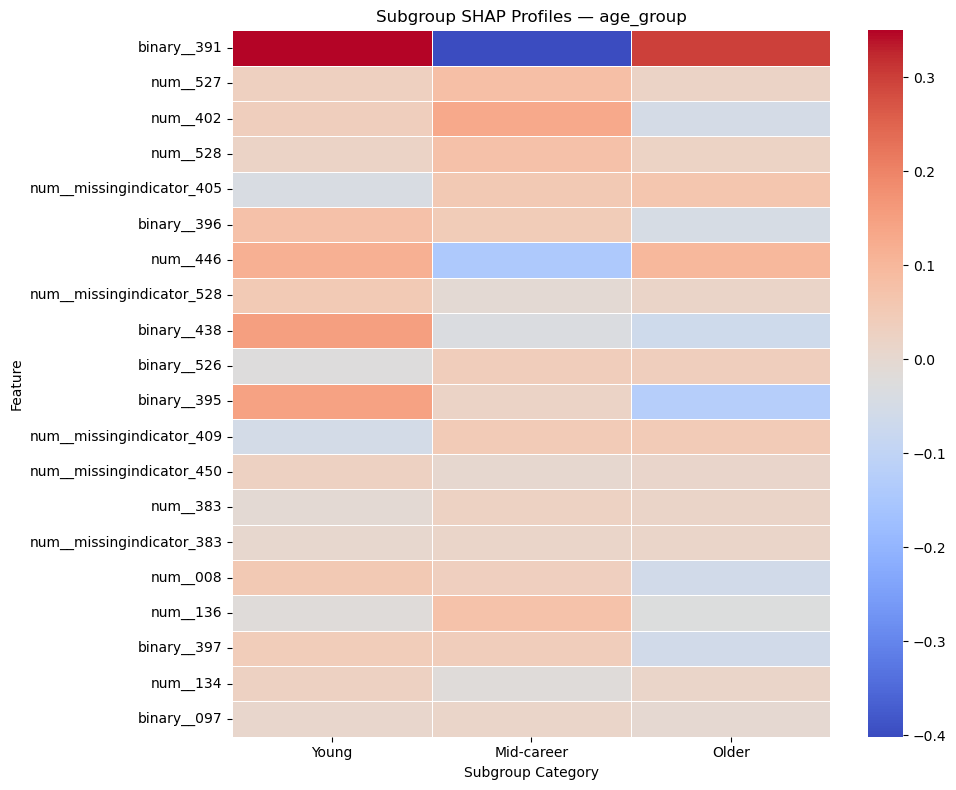

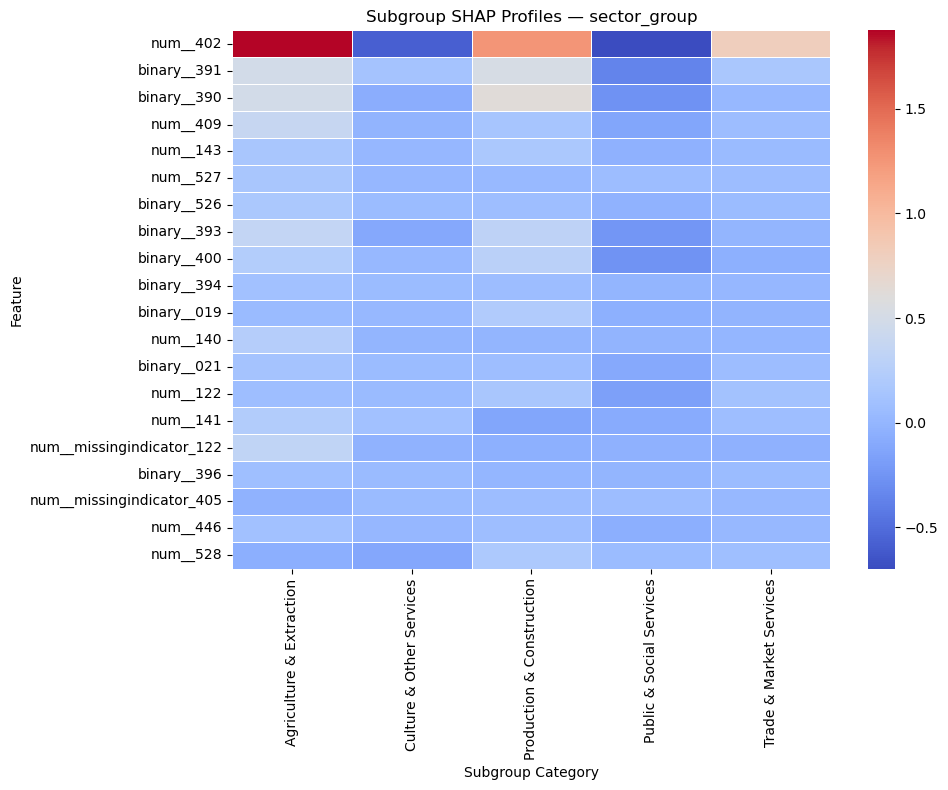

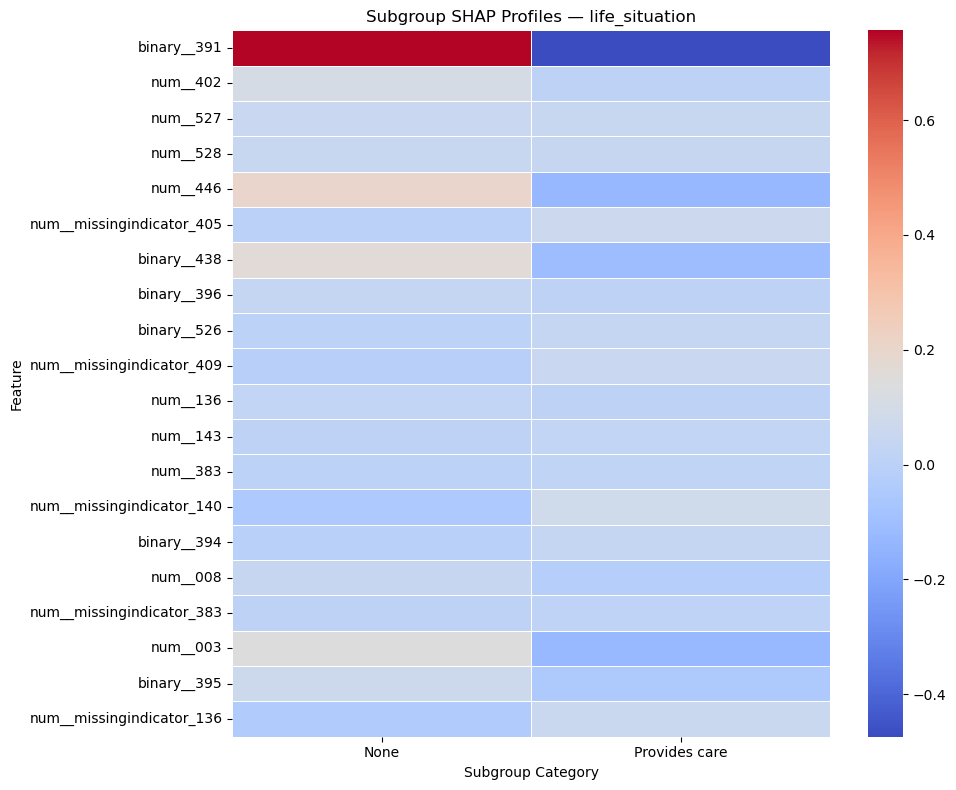

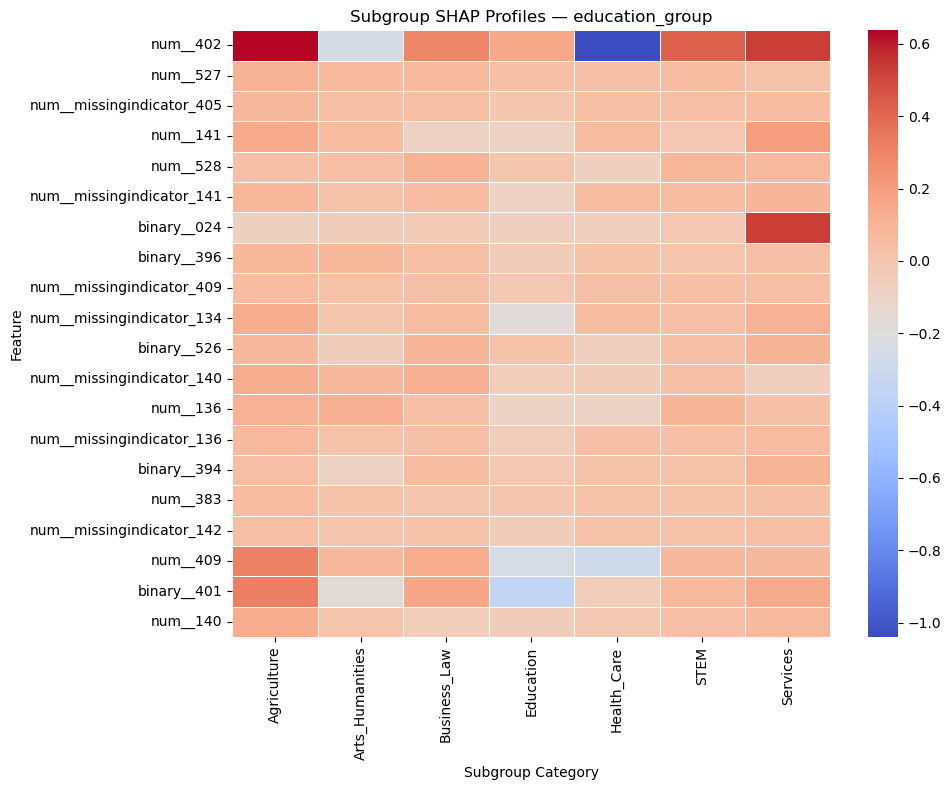


=== Running subgroup SHAP analysis for Regime C ===


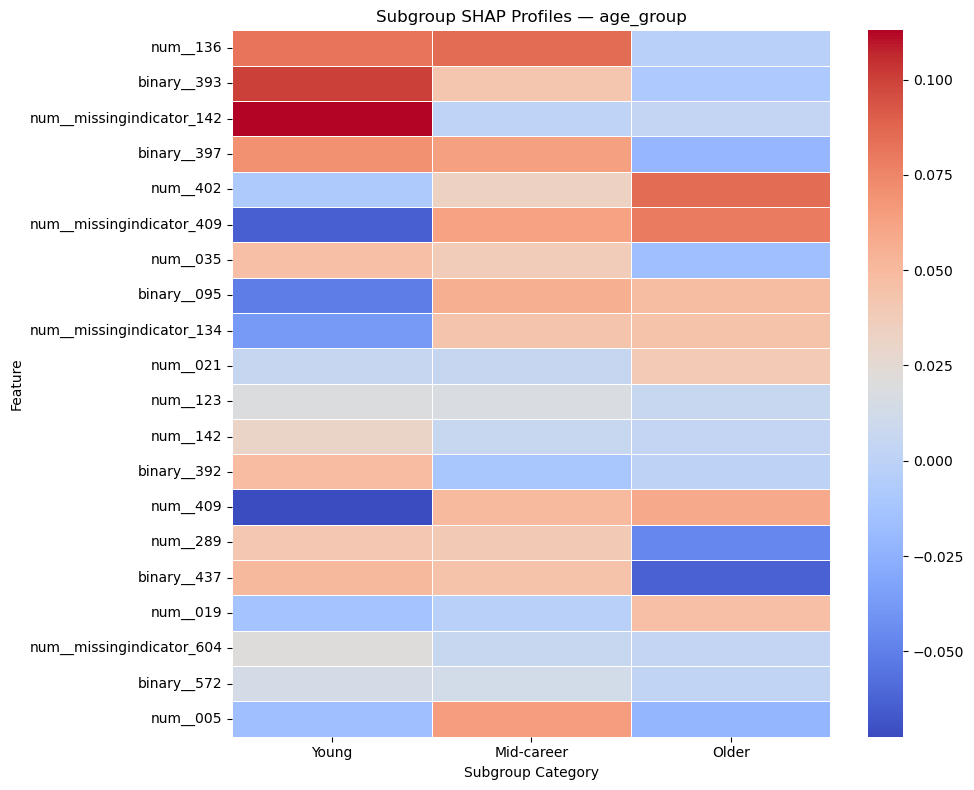

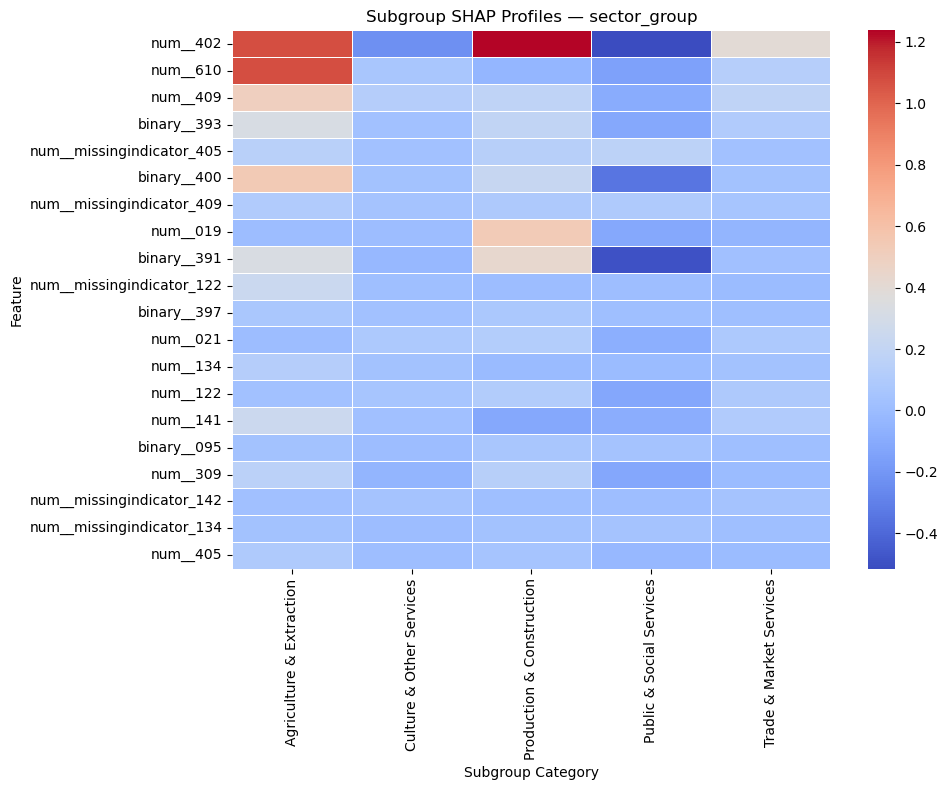

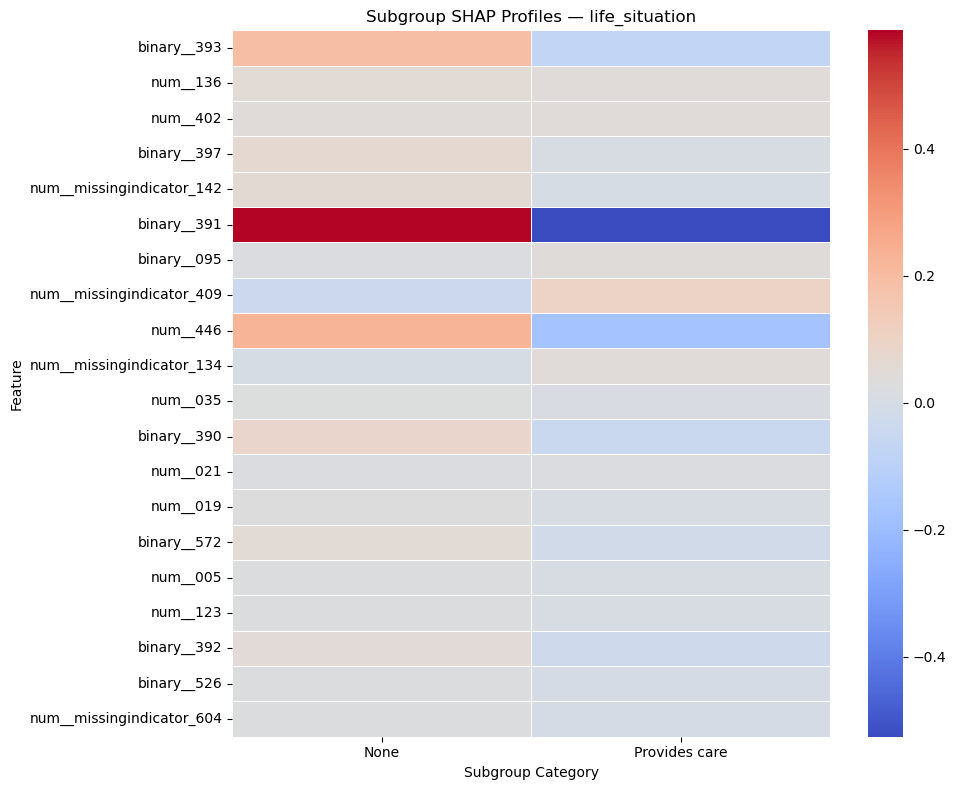

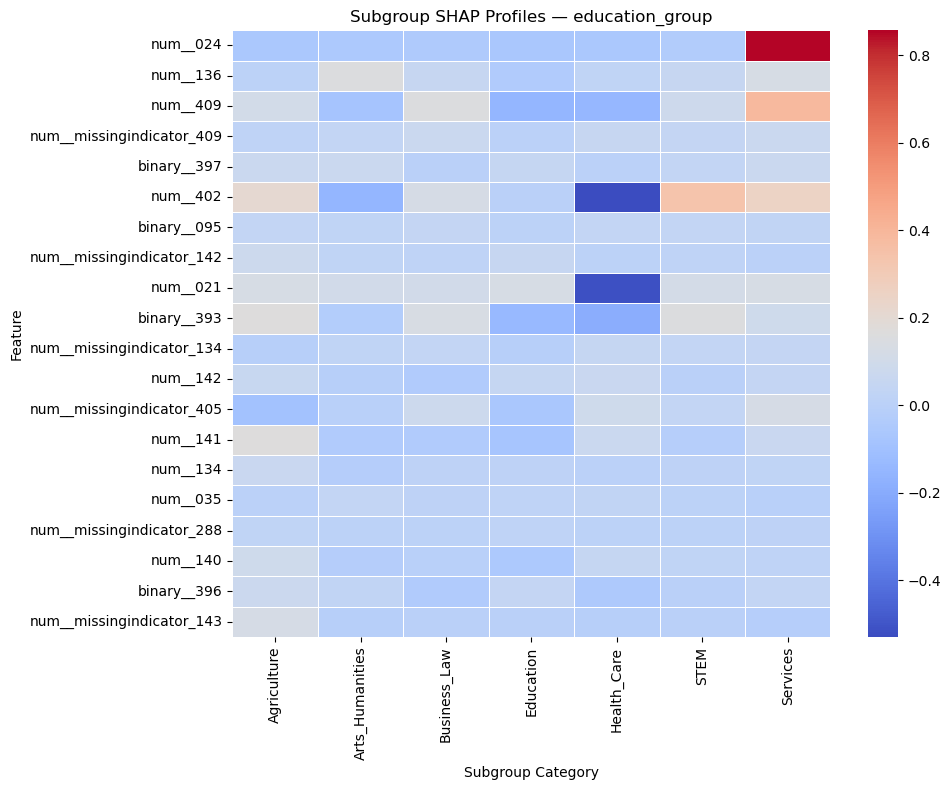


=== Subgroup SHAP analysis completed for all regimes ===


In [12]:
# Extract common features across regimes
common_features = across_regime_results_loaded["common_features_raw"]

print("Number of common features:", len(common_features))
print("Example:", common_features[:10])


all_subgroup_results = {}

raw_dfs = {
    "Regime A": df_regime_a,
    "Regime B": df_regime_b,
    "Regime C": df_regime_c
}

for regime_name in shap_results_per_regime.keys():
    print(f"\n=== Running subgroup SHAP analysis for {regime_name} ===")

    shap_res = shap_results_per_regime[regime_name]
    shap_values = shap_res["shap_values"]
    feature_names = shap_res["X_full"].columns

    model_name = "XGBoost"
    X_test = ALL_RESULTS[regime_name]["results"][model_name]["X_test"]

    df_regime_raw = raw_dfs[regime_name]

    subgroup_results = compute_subgroup_shap_analysis(
        shap_values=shap_values,
        X_test=X_test,
        df_regime_raw=df_regime_raw,
        feature_names=feature_names,
        build_subgroups_fn=build_subgroups,
        top_n=20
    )


    # Restrict subgroup profiles to common features
    subgroup_profiles_common = {
        subgroup: profile.loc[common_features]
        for subgroup, profile in subgroup_results["subgroup_profiles"].items()
        if set(common_features).issubset(profile.index)
    }

    # Compute rank variance for common features
    subgroup_rank_variance_common = {}
    for subgroup, profile in subgroup_profiles_common.items():
        rank_df = profile.rank(ascending=False, axis=0)
        rank_var = rank_df.var(axis=1).sort_values(ascending=False)
        subgroup_rank_variance_common[subgroup] = rank_var

    # Store everything
    all_subgroup_results[regime_name] = {
        "shap_df": subgroup_results["shap_df"],
        "subgroup_cols": subgroup_results["subgroup_cols"],
        "subgroup_profiles_full": subgroup_results["subgroup_profiles"],
        "subgroup_profiles_common": subgroup_profiles_common,
        "rank_variance_full": subgroup_results["subgroup_rank_variance"],
        "rank_variance_common": subgroup_rank_variance_common
    }

print("\n=== Subgroup SHAP analysis completed for all regimes ===")


In [13]:
feature_name_map = {
    # -------------------------
    # Your original mappings
    # -------------------------
    "num__143": "Has sideline job",
    "num__409": "Supervises employees",
    "num__446": "Works less to care for children",
    "binary__391": "Reason <36h: family situation",
    "binary__390": "Reason <36h: no opportunity to work more",
    "binary__393": "Reason <36h: home activities",
    "binary__401": "Reason <36h: other",
    "binary__400": "Reason <36h: more leisure",
    "binary__088": "Currently employed",
    "num__404": "Occupation (current job)",
    "num__402": "Sector",
    "num__122": "Retirement feeling",
    "num__289": "Expected retirement age",
    "num__008": "Education completed (2nd degree)",
    "num__479": "Savings deposit (2007)",
    "num__384": "Max full-time wage estimate",
    "num__136": "Commute to work (minutes)",
    "num__032": "Education–work match scale",
    "num__003": "Age",
    "num__022": "Preferred retirement age",
    "num__459": "Lifecourse deposit (2007)",
    "num__438": "No children or grandchildren",
    "num__450": "Provides informal care",
    "num__123": "Organisation type (first job)",
    "num__035": "Has taken job courses",
    "binary__437": "Has grandchildren",
    "binary__492": "Reason <36h: family/health",
    "num__missingindicator_141": "Missing: weekend work frequency",
    "num__missingindicator_142": "Missing: evening work frequency",
    "num__missingindicator_517": "Missing: minimum wage offer",
    "num__missingindicator_405": "Missing: occupation (first job)",
    "num__missingindicator": "Missing: irregular work hours",
    "num__411": "Option to continue working after pension",
    "num__missingindicator_411": "Missing: option to continue after pension",
    "num__missingindicator_134": "Missing: year started working",
    "num__517": "Minimum wage offer (EUR)",
    "num__missingindicator_035": "Missing: took job courses",
    "num__missingindicator_528": "Missing: workplace size",
    "num__611": "Profession (ISCO 085)",
    "num__missingindicator_309": "Missing: desired part-time hours",
    "num__missingindicator_136": "Missing: commute to work (minutes)",
    "num__005": "Highest Dutch education",
    "num__308": "Retirement transition preference",
    "num__610": "Weekly home-work hours",
    "num__309": "Desired part-time hours",
    "num__134": "Year started working",
    "num__528": "Workplace size",
    "num__141": "Weekend work frequency",
    "binary__395": "Reason <36h: health",

    # -------------------------
    # Your NEW improved mappings
    # -------------------------
    "binary__438": "No children or grandchildren",
    "binary__396": "Reason <36h: disability",
    "num__439": "Has children under age 8",
    "binary__436": "Has children",
    "binary__393": "Reason <36h: home activities",   # updated from your note
    "num__288": "Stopped working age",
    "num__140": "Evening work frequency",
    "binary__101": "Does voluntary work",
    "binary__096": "Does household work",
    "num__405": "Occupation (first job)",
    "num__missingindicator_122": "Missing: organisation type (current job)",
    "num__missingindicator_140": "Missing: evening work frequency",
    "binary__394": "Reason <36h: other activities",
    "binary__397": "Reason <36h: partial retirement",
    "binary__392": "Reason <36h: family/health",
    "num__missingindicator_409": "Missing: supervises employees",
    "num__missingindicator_450": "Missing: provides informal care",
    "num__missingindicator_122": "Missing: organisation type (current job)"
}

feature_name_map.update({
    "binary__095": "Is student with expense claim",
    "binary__399": "Reason <36h: take it easier"
})


In [14]:
TOP_N = 15

for regime_name, results in all_subgroup_results.items():
    print("\n" + "="*80)
    print(f"SUBGROUP PROFILES (TOP {TOP_N} COMMON FEATURES) — {regime_name}")
    print("="*80)

    for subgroup, profile in results["subgroup_profiles_common"].items():
        # Select top 15 features by mean SHAP across subgroups
        top_features = (
            profile.mean(axis=1)
            .sort_values(ascending=False)
            .head(TOP_N)
            .index
        )

        print(f"\n--- {subgroup} ---")
        print(profile.loc[top_features])



SUBGROUP PROFILES (TOP 15 COMMON FEATURES) — Regime A

--- age_group ---
age_group       Young  Mid-career     Older
binary__391  0.516676   -0.564752  0.497493
num__446     0.150671   -0.169026  0.201789
binary__438  0.201821   -0.019569 -0.051261
num__122     0.075291    0.024439  0.000813
binary__396  0.103446    0.029012 -0.059795
binary__096  0.038004   -0.020764  0.051969
num__439     0.018377   -0.041049  0.078891
binary__436  0.056653   -0.004620 -0.005535
binary__392  0.028220    0.015769  0.000402
num__140    -0.029221    0.033584  0.035021
num__402    -0.058572    0.115318 -0.019662
binary__101  0.033203   -0.002239  0.002574
num__288     0.019520    0.003798  0.006304
num__289     0.123824    0.056010 -0.150292
num__141     0.074568   -0.042103 -0.011668

--- sector_group ---
sector_group               Agriculture & Extraction  Culture & Other Services  \
num__402                                   1.537706                 -0.252765   
num__409                              

In [15]:
for regime_name, results in all_subgroup_results.items():
    print("\n" + "="*80)
    print(f"RANK VARIANCE (TOP {TOP_N} COMMON FEATURES) — {regime_name}")
    print("="*80)

    for subgroup, rank_var in results["rank_variance_common"].items():
        top_features = rank_var.head(TOP_N)

        print(f"\n--- {subgroup} ---")
        print(top_features)



RANK VARIANCE (TOP 15 COMMON FEATURES) — Regime A

--- age_group ---
binary__391                  1281.333333
num__446                     1161.333333
num__missingindicator_035    1143.000000
binary__095                  1102.333333
num__409                     1029.000000
num__003                     1026.333333
binary__393                  1017.333333
binary__401                   984.333333
num__404                      940.333333
binary__399                   937.333333
binary__400                   903.000000
binary__438                   871.000000
binary__395                   867.000000
binary__390                   829.000000
num__289                      758.333333
dtype: float64

--- sector_group ---
num__402                     1116.8
num__141                      920.5
num__404                      915.2
num__missingindicator_035     763.5
num__409                      757.3
binary__390                   713.3
binary__401                   709.5
binary__391               

In [16]:
cross_regime_stability = {}

for subgroup in all_subgroup_results["Regime A"]["rank_variance_common"].keys():
    df = pd.DataFrame({
        regime_name: results["rank_variance_common"][subgroup]
        for regime_name, results in all_subgroup_results.items()
    })

    # Select top 15 features by average variance across regimes
    top_features = (
        df.mean(axis=1)
        .sort_values(ascending=False)
        .head(TOP_N)
        .index
    )

    cross_regime_stability[subgroup] = df.loc[top_features]

# Print them
for subgroup, df in cross_regime_stability.items():
    print("\n" + "="*80)
    print(f"CROSS‑REGIME SUBGROUP STABILITY (TOP {TOP_N}) — {subgroup}")
    print("="*80)
    print(df)



CROSS‑REGIME SUBGROUP STABILITY (TOP 15) — age_group
                              Regime A     Regime B     Regime C
binary__391                1281.333333  1261.000000  1261.000000
num__missingindicator_035  1143.000000  1281.333333  1261.000000
num__003                   1026.333333  1240.333333  1241.333333
num__446                   1161.333333  1066.333333  1180.333333
binary__401                 984.333333  1012.333333   960.333333
binary__399                 937.333333   817.000000   936.333333
binary__400                 903.000000   917.333333   849.000000
binary__390                 829.000000   850.333333   960.333333
binary__393                1017.333333  1121.333333   399.000000
num__409                   1029.000000   641.333333   696.333333
binary__395                 867.000000   684.333333   772.333333
num__404                    940.333333   956.333333   268.000000
num__missingindicator_136   296.333333   691.000000  1083.000000
num__missingindicator_405   625.3333

In [17]:
all_subgroup_results_readable = {}

for regime_name, results in all_subgroup_results.items():

    readable_profiles = {
        subgroup: rename_features(profile, feature_name_map)
        for subgroup, profile in results["subgroup_profiles_common"].items()
    }

    readable_rank_var = {
        subgroup: rename_features(rank_var.to_frame("Rank Variance"), feature_name_map)
        for subgroup, rank_var in results["rank_variance_common"].items()
    }

    all_subgroup_results_readable[regime_name] = {
        "subgroup_profiles_common": readable_profiles,
        "rank_variance_common": readable_rank_var
    }


In [18]:
cross_regime_stability_readable = {}

for subgroup, df in cross_regime_stability.items():
    cross_regime_stability_readable[subgroup] = rename_features(df, feature_name_map)


In [19]:
TOP_N = 15

for regime_name, results in all_subgroup_results_readable.items():
    print("\n" + "="*80)
    print(f"SUBGROUP PROFILES (TOP {TOP_N}) — {regime_name}")
    print("="*80)

    for subgroup, profile in results["subgroup_profiles_common"].items():
        top_features = (
            profile.mean(axis=1)
            .sort_values(ascending=False)
            .head(TOP_N)
            .index
        )
        print(f"\n--- {subgroup} ---")
        print(profile.loc[top_features])



SUBGROUP PROFILES (TOP 15) — Regime A

--- age_group ---
age_group                           Young  Mid-career     Older
Reason <36h: family situation    0.516676   -0.564752  0.497493
Works less to care for children  0.150671   -0.169026  0.201789
No children or grandchildren     0.201821   -0.019569 -0.051261
Retirement feeling               0.075291    0.024439  0.000813
Reason <36h: disability          0.103446    0.029012 -0.059795
Does household work              0.038004   -0.020764  0.051969
Has children under age 8         0.018377   -0.041049  0.078891
Has children                     0.056653   -0.004620 -0.005535
Reason <36h: family/health       0.028220    0.015769  0.000402
Evening work frequency          -0.029221    0.033584  0.035021
Sector                          -0.058572    0.115318 -0.019662
Does voluntary work              0.033203   -0.002239  0.002574
Stopped working age              0.019520    0.003798  0.006304
Expected retirement age          0.123824    0

In [20]:
for regime_name, results in all_subgroup_results_readable.items():
    print("\n" + "="*80)
    print(f"RANK VARIANCE (TOP {TOP_N}) — {regime_name}")
    print("="*80)

    for subgroup, rank_var in results["rank_variance_common"].items():
        print(f"\n--- {subgroup} ---")
        print(rank_var.head(TOP_N))



RANK VARIANCE (TOP 15) — Regime A

--- age_group ---
                                          Rank Variance
Reason <36h: family situation               1281.333333
Works less to care for children             1161.333333
Missing: took job courses                   1143.000000
Is student with expense claim               1102.333333
Supervises employees                        1029.000000
Age                                         1026.333333
Reason <36h: home activities                1017.333333
Reason <36h: other                           984.333333
Occupation (current job)                     940.333333
Reason <36h: take it easier                  937.333333
Reason <36h: more leisure                    903.000000
No children or grandchildren                 871.000000
Reason <36h: health                          867.000000
Reason <36h: no opportunity to work more     829.000000
Expected retirement age                      758.333333

--- sector_group ---
                            

In [21]:
for subgroup, df in cross_regime_stability_readable.items():
    top_features = (
        df.mean(axis=1)
        .sort_values(ascending=False)
        .head(TOP_N)
        .index
    )
    print("\n" + "="*80)
    print(f"CROSS‑REGIME STABILITY (TOP {TOP_N}) — {subgroup}")
    print("="*80)
    print(df.loc[top_features])



CROSS‑REGIME STABILITY (TOP 15) — age_group
                                             Regime A     Regime B  \
Reason <36h: family situation             1281.333333  1261.000000   
Missing: took job courses                 1143.000000  1281.333333   
Age                                       1026.333333  1240.333333   
Works less to care for children           1161.333333  1066.333333   
Reason <36h: other                         984.333333  1012.333333   
Reason <36h: take it easier                937.333333   817.000000   
Reason <36h: more leisure                  903.000000   917.333333   
Reason <36h: no opportunity to work more   829.000000   850.333333   
Reason <36h: home activities              1017.333333  1121.333333   
Supervises employees                      1029.000000   641.333333   
Reason <36h: health                        867.000000   684.333333   
Occupation (current job)                   940.333333   956.333333   
Missing: commute to work (minutes)         29